N.B. This is a notebook I created for my talk at [Hopperx1 London 2019](https://community.anitab.org/event/hopperx1-london/) organised by fabulous people at [AnitaB.org](https://anitab.org/).

It is best served as an interactive HTML slide deck using [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html), as otherwise the styling of most HTML elements will be completely off!

Here's how to do it. From your terminal, run:

```
$ jupyter nbconvert presentation/hopperx1.ipynb --to slides --post serve
```

It should open up a browser automatically.

Modify the path to this notebook depending on where you're lauching it from.

In [1]:
###########
# Imports #
###########

#####################
# Utility functions #
#####################

<div class='title'>
    <h1 id='main-title'>Seeing is believing</h1>

    <h3 id='subtitle'>Using FlashTorch 🔦 to shine a light on what neural nets "see"</h3>

    <hr>

    <p>by Misa Ogura</p>
</div>

<head>
    <link rel="stylesheet" href="https://use.fontawesome.com/releases/v5.8.2/css/all.css" integrity="sha384-oS3vJWv+0UjzBfQzYUhtDYW+Pj2yciDJxpsK1OYPAYjqT085Qq/1cq5FLXAZQ7Ay" crossorigin="anonymous">
<head>

<h1>Hello, I'm Misa 👋</h1>

<hr>

<div class='profile-container'>
    <img id='profile-image' src='images/misa_ogura_profile.jpg' width='200' height='200'>

    <ul id='profile-list'>
        <li>Originally from Tokyo, now based in London</li>
        <li>Cancer Cell Biologist, turned Software Engineer</li>
        <li>Currently at BBC R&D</li>
        <li>Co-founder of Women Driven Development</li>
        <li>Women in Data Science London Ambassador</li>
    </ul>
</div>


<div class='social-container'>
    <a href='https://github.com/misaogura' target='_blank'><i class="fab fa-github"></i></a>
    <a href='https://medium.com/@misaogura' target='_blank'><i class="fab fa-medium-m"></i></a>
    <a href='https://twitter.com/misa_ogura' target='_blank'><i class="fab fa-twitter"></i></a>
    <a href='https://www.linkedin.com/in/misaogura/' target='_blank'><i class="fab fa-linkedin-in"></i></a>
    <a href='https://womendrivendev.org' target='_blank'>
        <img id='wdd-logo' src='images/wdd-logo.png' width='20' height='20'>
    </a>
</div>

## Convolutional Neural Network (CNN)

---

### Typical CNN Architecture

---

<img id='cnn' src='images/cnn.png' width='800'>

### Image Convolution

---

## CNN Visualisation Techniques

---

### Saliency map

---

### Activation maximisation

---

## Demo 1

### Introducing FlashTorch & how to visualise saliency maps
---

### First things first - config & imports

---

```
$ pip install flashtorch
```

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models

### Load an image

---

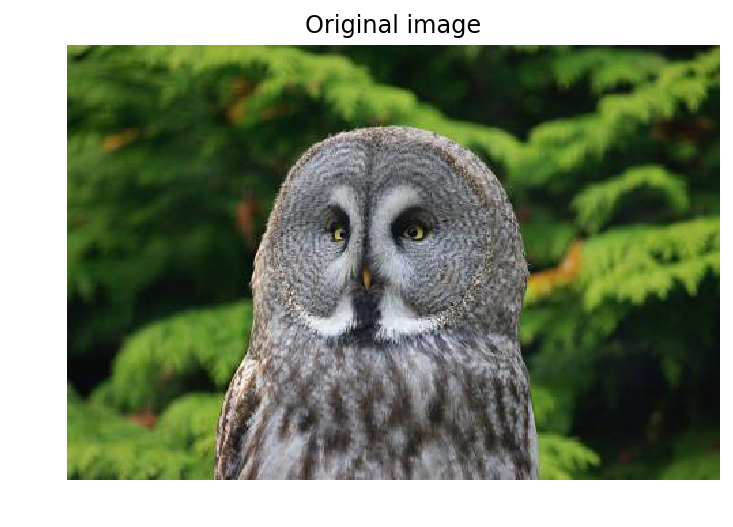

In [3]:
from flashtorch.utils import load_image

image = load_image('../examples/images/great_grey_owl_01.jpg')

plt.imshow(image)
plt.title('Original image')
plt.axis('off');

### Convert the PIL image to a torch tensor

---

In [4]:
from flashtorch.utils import apply_transforms

input_ = apply_transforms(image)

print(f'Before: {type(image)}')
print(f'After: {type(input_)}, {input_.shape}')

Before: <class 'PIL.Image.Image'>
After: <class 'torch.Tensor'>, torch.Size([1, 3, 224, 224])


### Let's visualise the input first...

---

In [5]:
# plt.imshow(input_)
# plt.title('Input tensor')
# plt.axis('off');

```
RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
```

### Let's visualise the input (take two)

---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


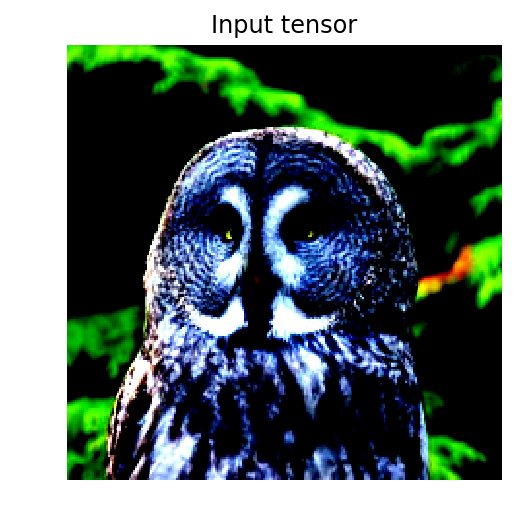

In [6]:
from flashtorch.utils import format_for_plotting

plt.imshow(format_for_plotting(input_))
plt.title('Input tensor')
plt.axis('off');

### Let's visualise the input (take THREE)

---

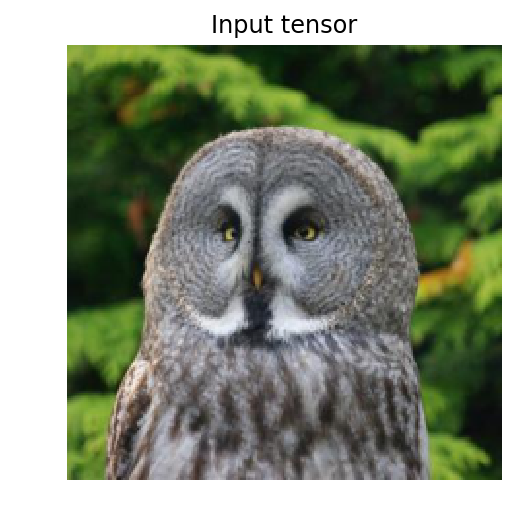

In [7]:
from flashtorch.utils import denormalize

plt.imshow(format_for_plotting(denormalize(input_)))
plt.title('Input tensor')
plt.axis('off');

### Load a pre-trained model & create a backprop object

---

In [8]:
from flashtorch.saliency import Backprop

model = models.alexnet(pretrained=True)

backprop = Backprop(model)

```
Signature:

    backprop.calculate_gradients(input_, target_class=None, take_max=False)
```

### Retrieve the class index for the object in the input

---

In [9]:
from flashtorch.utils import ImageNetIndex 

imagenet = ImageNetIndex()
target_class = imagenet['great grey owl']

print(target_class)

24


### It kind of does fuzzy-matching as well (to some extent...)

---

In [10]:
# imagenet['dog']

```
ValueError: Multiple potential matches found: maltese dog, old english sheepdog, shetland sheepdog, greater swiss mountain dog, bernese mountain dog, french bulldog, eskimo dog, african hunting dog, dogsled, hotdog
```

### Finally! It's time to calculate the gradients of each pixel w.r.t. the input image

---

In [11]:
gradients = backprop.calculate_gradients(input_, target_class)

print(type(gradients), gradients.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


### You can also take the maximum of the gradients across colour channels

---

In [12]:
max_gradients = backprop.calculate_gradients(input_, target_class, take_max=True)

print(type(max_gradients), max_gradients.shape)

<class 'torch.Tensor'> torch.Size([1, 224, 224])


### Let's inspect gradients by plotting them out

---

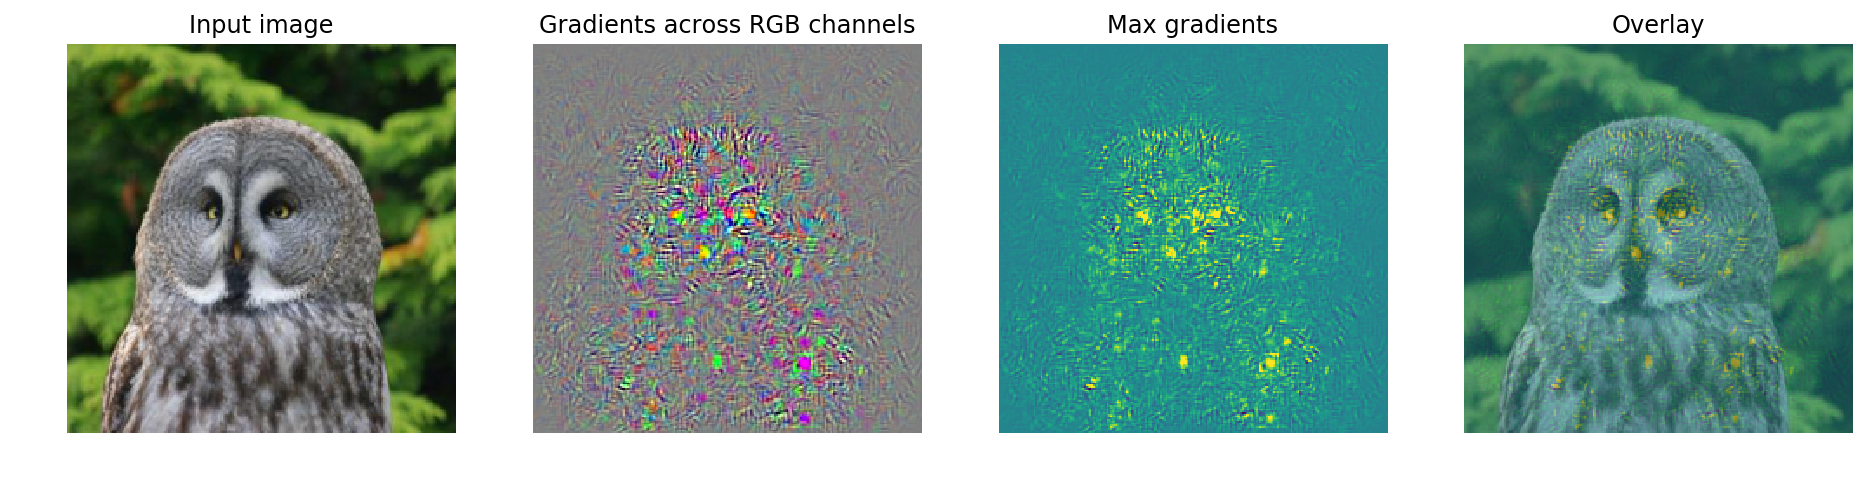

In [13]:
from flashtorch.utils import visualize

visualize(input_, gradients, max_gradients)

It kind of shows that pixels around the area **where the animal is present** had strongest positive effects on the prediction.

But it's quite noisy...

### Guided backprop to the rescue!

---

In [14]:
guided_gradients = backprop.calculate_gradients(input_, target_class, guided=True)
max_guided_gradients = backprop.calculate_gradients(input_, target_class, take_max=True, guided=True)

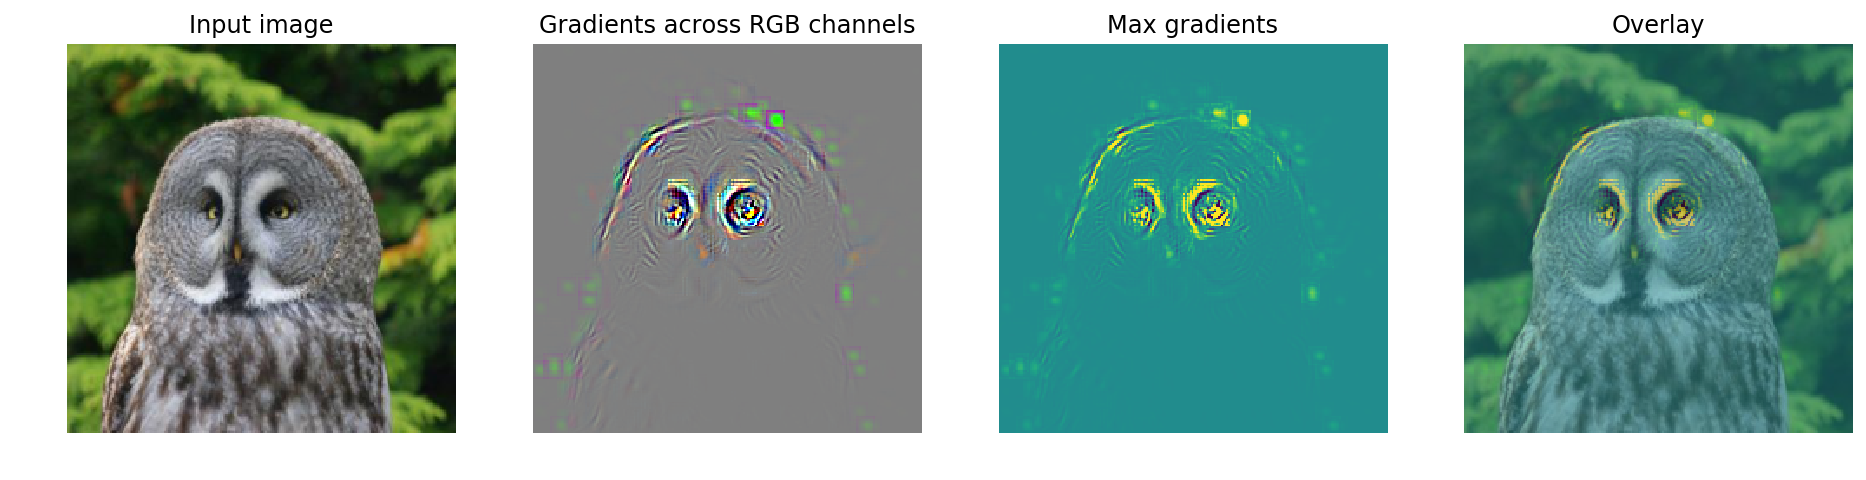

In [15]:
visualize(input_, guided_gradients, max_guided_gradients)

Now that's much less noisy!

We can clearly see that pixels around the **head and eyes** had strongest positive effects on the prediction.

### What about a jay?

---

In [16]:
input_ = apply_transforms(load_image('../examples/images/jay_01.jpg'))
target_class = imagenet['jay']

guided_gradients = backprop.calculate_gradients(input_, target_class, guided=True)
max_guided_gradients = backprop.calculate_gradients(input_, target_class, take_max=True, guided=True)

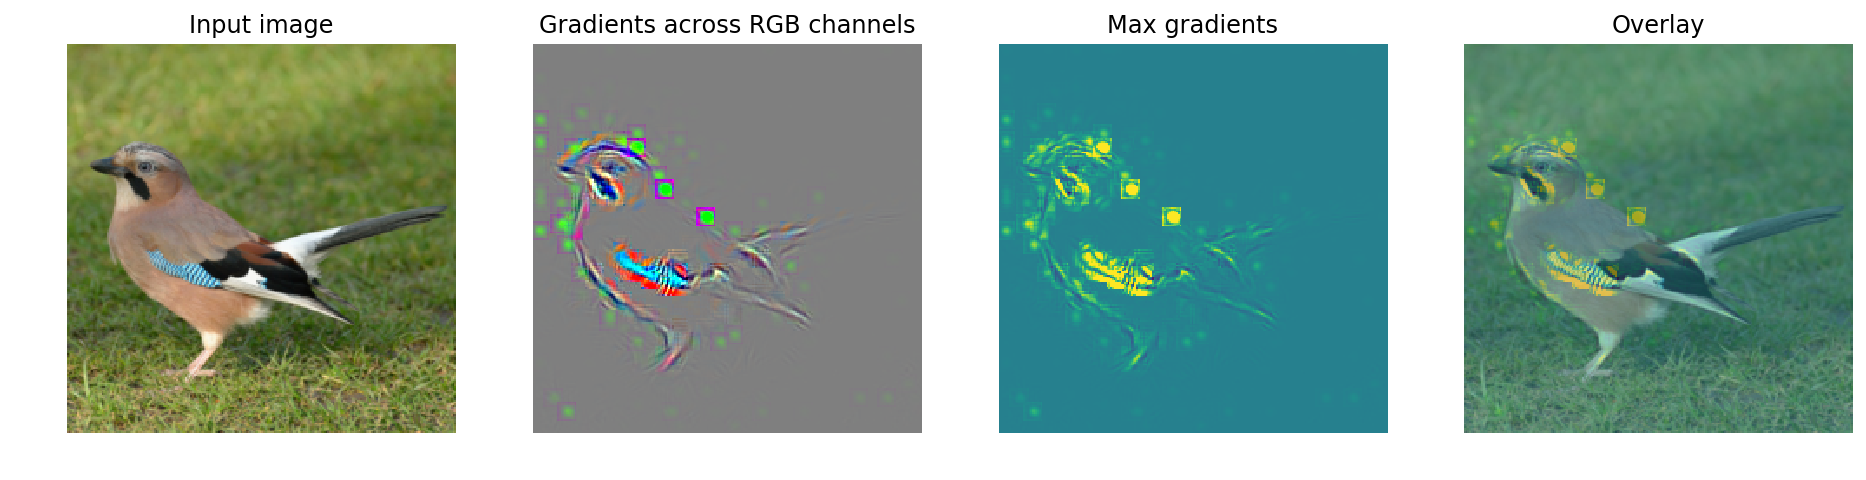

In [17]:
visualize(input_, guided_gradients, max_guided_gradients)

### Or an oystercatcher...

---

In [18]:
input_ = apply_transforms(load_image('../examples/images/oystercatcher_01.jpg'))
target_class = imagenet['oytercathcer']

guided_gradients = backprop.calculate_gradients(input_, target_class, guided=True)
max_guided_gradients = backprop.calculate_gradients(input_, target_class, take_max=True, guided=True)

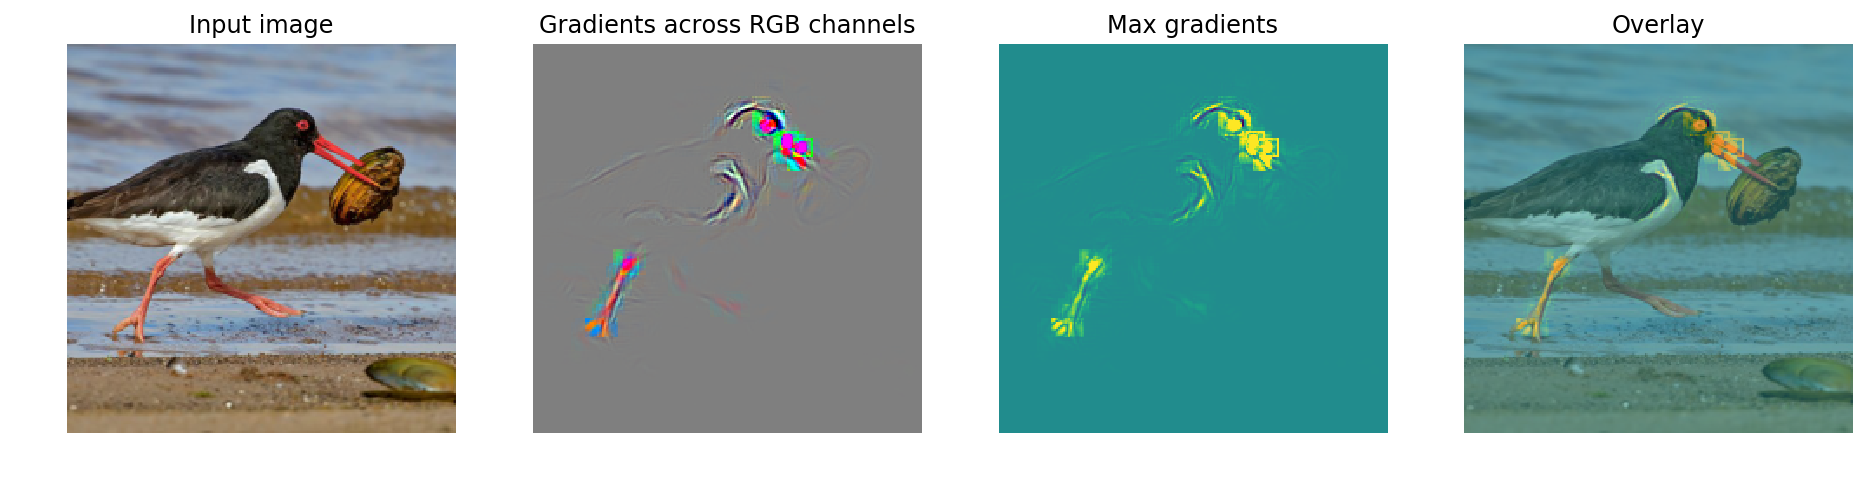

In [19]:
visualize(input_, guided_gradients, max_guided_gradients)

## Demo 2

### Using FlashTorch to gain additional insights on transfer learning
---

In [20]:
def create_model(filepath=None):
    in_feats = 2208
    out_feats = 102  # Total num of classes

    if filepath is not None:
        model = models.densenet161()
    else:
        model = models.densenet161(pretrained=True)
        
    model.classifier = nn.Sequential(nn.Linear(in_feats, out_feats),
                           nn.LogSoftmax(dim=1))

    if filepath is not None:
        checkpoint = torch.load(filepath, map_location='cpu')
        model.load_state_dict(checkpoint['state_dict'])
        
    for param in model.parameters():
        param.requires_grad = False
    
    return model

/Users/misao/Projects/personal/flashtorch/flashtorch/saliency/backprop.py:93: UserWarning: The predicted class does not equal the
                target class. Calculating the gradient with respect to the
                predicted class.
  predicted class.'''))


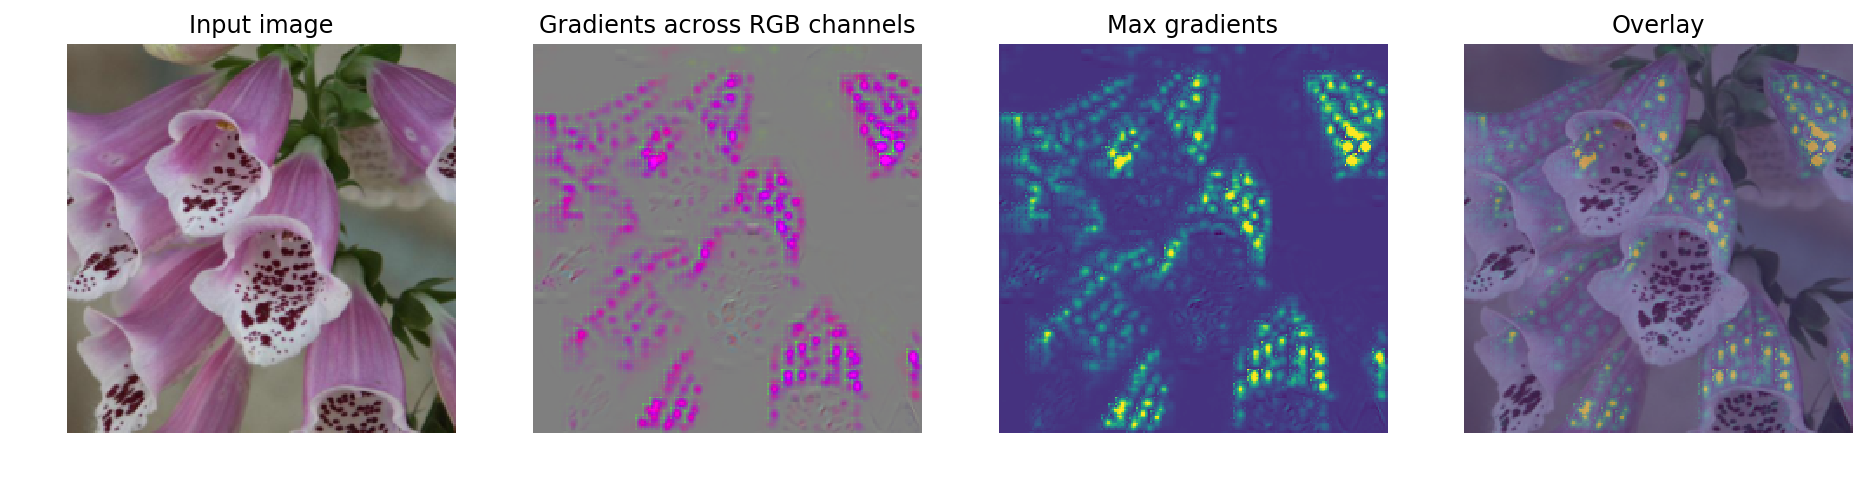

In [21]:
image = load_image('../examples/images/foxglove.jpg')
input_ = apply_transforms(image)

class_index = 96  # foxglove

pretrained_model = create_model()

backprop = Backprop(pretrained_model)

guided_gradients = backprop.calculate_gradients(input_, class_index, guided=True)
guided_max_gradients = backprop.calculate_gradients(input_, class_index, take_max=True, guided=True)

visualize(input_, guided_gradients, guided_max_gradients)

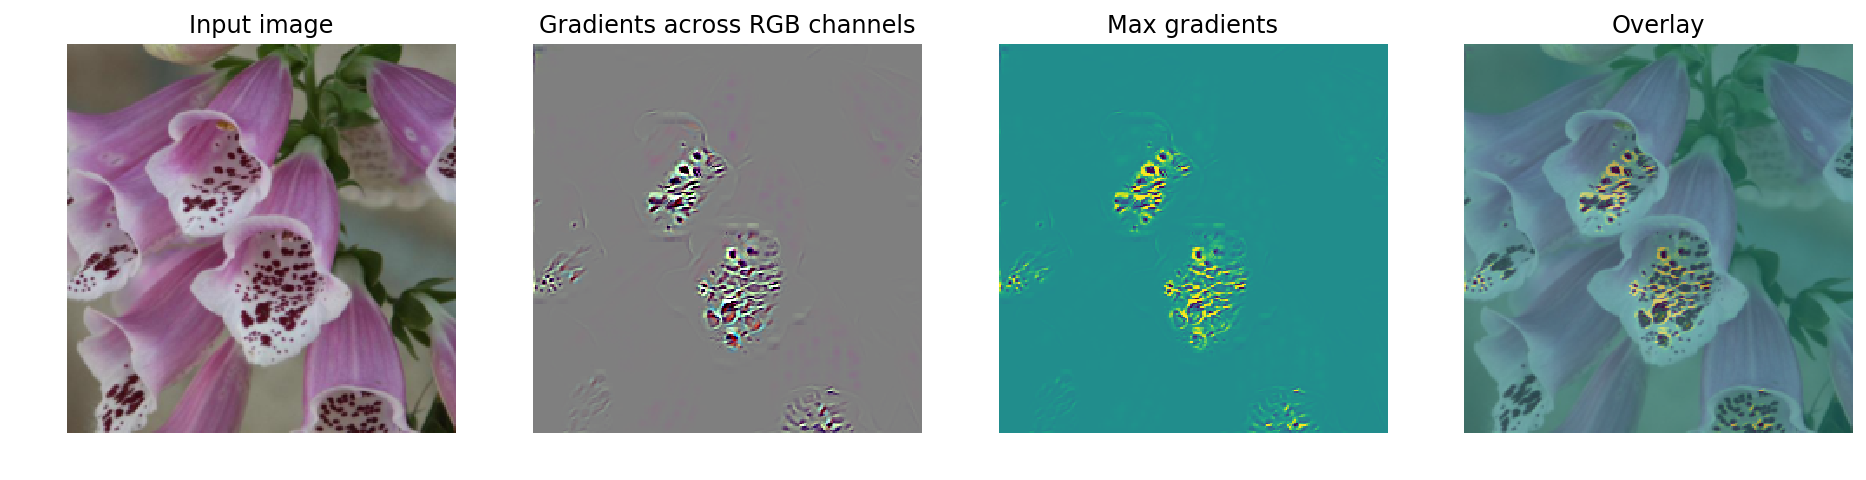

In [22]:
trained_model = create_model('../models/flower_classification_transfer_learning.pt')

backprop = Backprop(trained_model)

guided_gradients = backprop.calculate_gradients(input_, class_index, guided=True)
guided_max_gradients = backprop.calculate_gradients(input_, class_index, take_max=True, guided=True)

visualize(input_, guided_gradients, guided_max_gradients)